# 循环神经网络

## 动手实现循环神经网络

In [2]:
import math

import torch
from torch import nn
import numpy as np

from datasets import *

观察RNN的计算公式：
$$h_t=\sigma (W_h x_t+U_h h_{t-1} + b_h),\ y_t=\sigma (W_y h_t+b_y)$$
其中$x_t$是t步的输入；$h_t$是t步的隐藏状态，需要我们初始化，并在每步间循环更新；$W_h,W_y,b_h,b_y$则是可学习参数；$\sigma$是激活函数，计算新的隐藏状态时一般使用Tanh，计算状态时需要考虑我们期望的输出的范围。例如，希望输出为非负，则使用ReLU。

为了方便管理，我们将所有参数和计算过程集中在一个类中。

In [2]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

使用随机生成的数据进行简单的测试：

In [3]:
device = 'cuda:0'  # 如果电脑上无Nvidia显卡或未安装CUDA框架，请更改为 'cpu'
batch_size = 64
seq_len = 12
input_size = 2
hidden_size = 32
output_size = 1

x = torch.rand(batch_size, seq_len, input_size).to(device)
rnn = MyRNN(input_size, hidden_size, output_size).to(device)
hidden, y = rnn(x)
print(hidden.shape, y.shape)

torch.Size([64, 32]) torch.Size([64, 12, 1])


## 使用RNN进行实验

结合上一章的数据处理方式，首先将原始数据处理为短序列，随后以batch的形式进行训练，并在测试集上计算结果。

### 数据处理

In [4]:
# 读取数据
KrakowData = KrakowDataset()
data_df = KrakowData.data
data_df.head()

,171_temperature,171_humidity,171_pressure,171_pm1,171_pm25,171_pm10
2017-01-01 00:00:00,0.254545,0.082803,0.731568,0.639130,0.592334,0.567627
2017-01-01 01:00:00,0.236364,0.082803,0.722620,0.560870,0.522648,0.505543
2017-01-01 02:00:00,0.254545,0.082803,0.708840,0.582609,0.547038,0.532151
2017-01-01 03:00:00,0.236364,0.082803,0.699893,0.626087,0.595819,0.578714
2017-01-01 04:00:00,0.236364,0.082803,0.691303,0.595652,0.564460,0.549889


我们使用预先定义的数据对象读取数据并预处理

之后调用数据集构造函数将处理后的数据封装为torch.utils.data.Dataset数据集，并构造dataloader

In [2]:
KrakowData = KrakowDataset()
train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

为了保证模型能够正常训练，模型的输入需要进行归一化。我们已经在KrakowDataset的初始化过程中进行了归一化。

在测试模型时，需要将数据反归一化以得到正常的测试结果。

### 模型初始化

为了能够实现可学习参数的更新，我们还需要提供合理的损失函数和优化器。

损失函数应当按照具体任务选择，对于我们这里的回归问题，一般使用MSELoss。

优化器可以从torch.optim中选择。我们这里选择Adam优化器。优化器初始化时，需要提供所有需要优化的参数。由于我们将模型放入了一个nn.Module的子类中，直接使用model.parameters()就可以得到所有参数。

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

> 顺便一说，如果需要同时优化多个模型的参数，使用下面的语句即可：

    model_a = MyRNN(input_size=1, hidden_size=32, output_size=1).to(device)
    model_b = MyRNN(input_size=1, hidden_size=32, output_size=1).to(device)
    optimizer = torch.optim.Adam(list(model_a.parameters()) + list(model_b.parameters())
    
> 这是因为model.parameters()是一个生成器，因此可以用list()得到所有参数的列表，然后用相加操作即可。

为了能够测试模型的预测性能，也需要选择一个或多个测试指标。指标的选择取决于具体任务。对于回归任务，一般使用RMSE、MAE和MAPE。

Scikit-learn中提供了MAE和MSE。RMSE可以通过再MSE上求根得到，MAPE则需要自己实现。

In [7]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

**在附带代码utils.py中已封装三种常用测试指标函数，可以直接使用**

### 进行训练


对于RNN的输出如何处理，也取决于具体的任务和模型设计。这里我们直接将RNN输出状态的最后一步作为对下一消失温度的预测，因为最后一步输出理论上包含了整个输入历史序列的信息。

**在utils.py脚本中同样封装了训练函数，可接收多种参数，可自行选用功能**

In [5]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0124, train rmse 30.3472, val loss 0.0012, val rmse 9.860388, time use 0.616s
*** epoch2, train loss 0.0040, train rmse 17.7410, val loss 0.0005, val rmse 6.382975, time use 0.425s
*** epoch3, train loss 0.0026, train rmse 14.2648, val loss 0.0004, val rmse 5.410335, time use 0.417s
*** epoch4, train loss 0.0020, train rmse 12.4767, val loss 0.0004, val rmse 5.375636, time use 0.417s
*** epoch5, train loss 0.0017, train rmse 11.5865, val loss 0.0004, val rmse 5.341609, time use 0.408s
*** epoch6, train loss 0.0015, train rmse 10.7077, val loss 0.0003, val rmse 4.659272, time use 0.434s
*** epoch7, train loss 0.0014, train rmse 10.3493, val loss 0.0003, val rmse 4.618892, time use 0.396s
*** epoch8, train loss 0.0013, train rmse 10.1445, val loss 0.0002, val rmse 4.089201, time use 0.432s
*** epoch9, train loss 0.0012, train rmse 9.6901, val loss 0.0002, val rmse 4.278735, time use 0.444s
*** epoch10, train loss 0.0011, train rmse 9.4174, val loss 0.0002, val rm

### 可视化训练结果

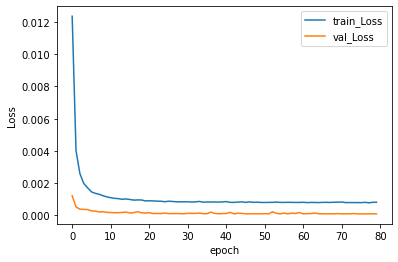

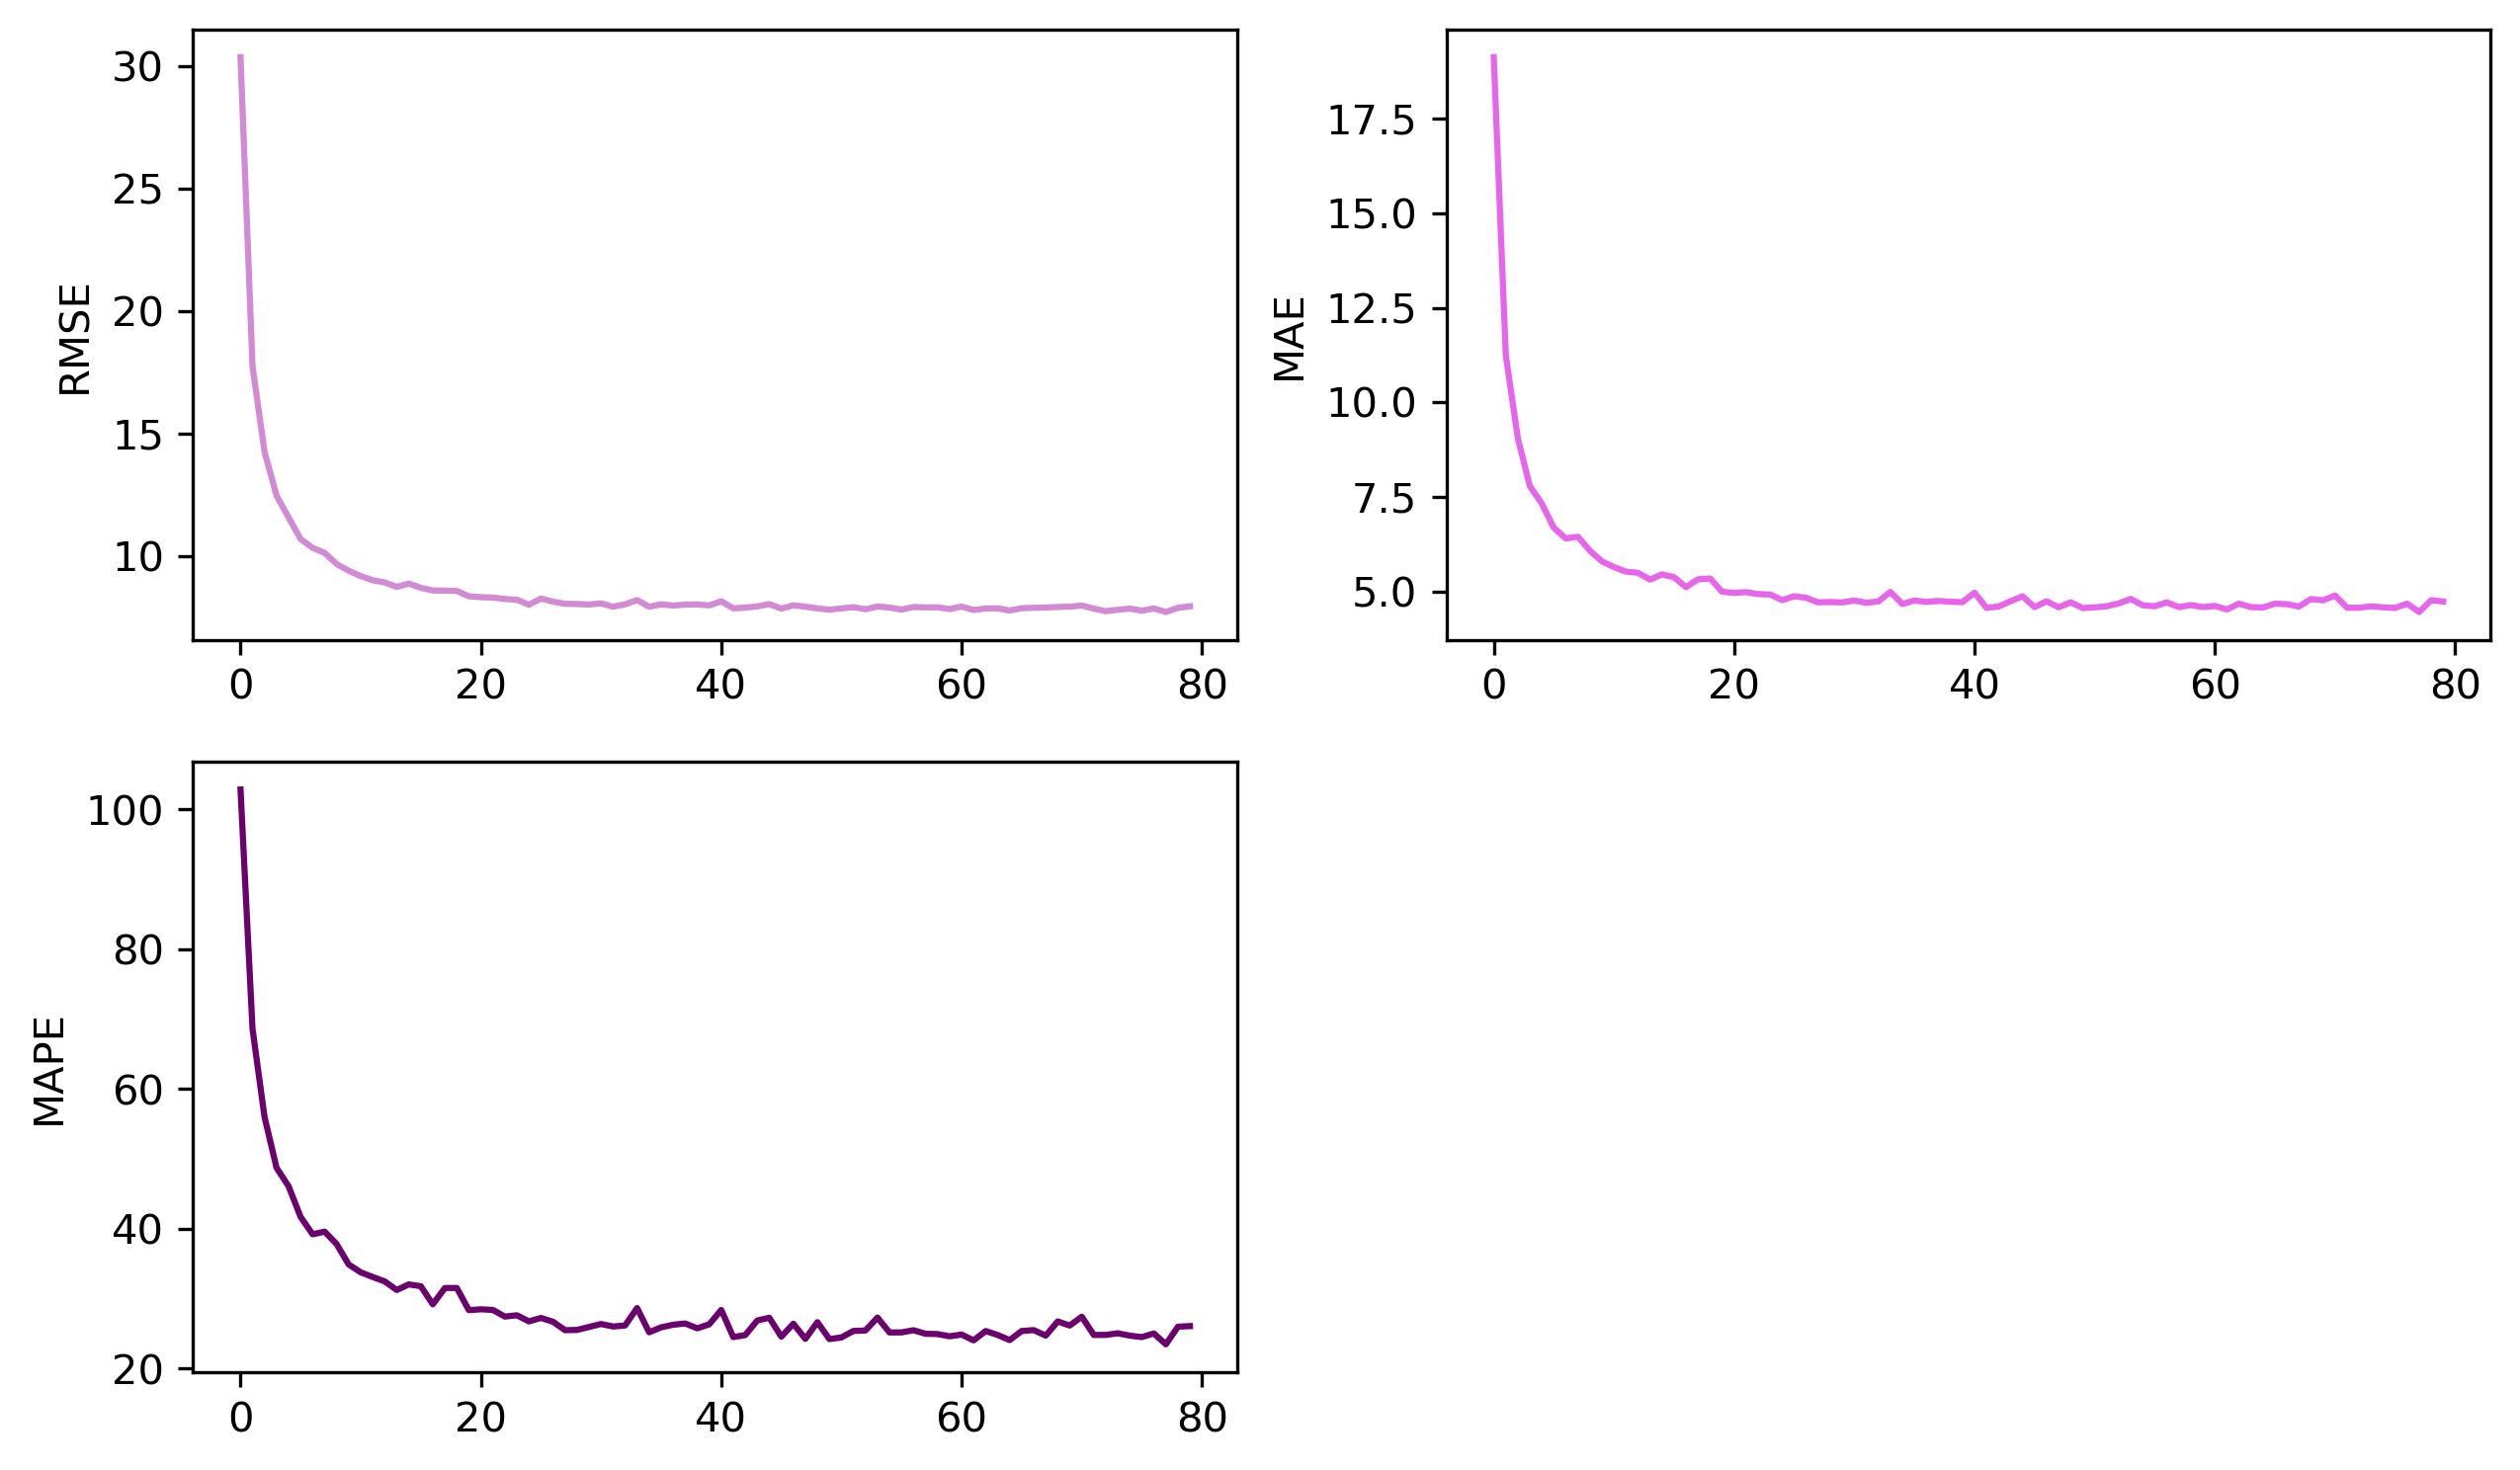

In [6]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## PyTorch封装RNN介绍

PyTorch中已经封装了一个可开箱即用的RNN模型，并且相比起我们的版本，其对RNN的实现更加完整，其中包括：

- 多层RNN
- 双向RNN

nn.RNN的使用方式很简单，其接口与我们的版本主要区别在于：

- 多了两个参数num_layers和bidirectional，分别用于实现多层RNN和双向RNN；
- 包含参数batch_first，控制输入的格式，下面会进一步解释；
- 并没有output_size参数，下面会进一步解释。

例如初始化一个4层，双向的RNN可以用一下语句：

In [13]:
bi_rnn = nn.RNN(input_size=2, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)

其使用方法与我们的版本也稍有区别，主要包括：

- 默认状态下，输入的格式不是(batch_size, seq_len, input_size)而是(seq_len, batch_size, input_size)。batch_size维度是否在第一维由参数batch_first控制。
- 内部实现并没有输出层，因此虽然输出仍然为(output, hidden)，但output实际上就是每一步的隐藏状态。需要我们自己再实现一个输出层。
    - 输出的hidden的格式为(num_layers * num_direction, batch_size, hidden_size)。其格式不受batch_first控制。
    - output的格式与输入是一致的，即默认状态下为(seq_len, batch_size, hidden_size)。
    
使用随机生成的数据进行测试：

In [14]:
device = 'cuda:0'
batch_size = 32
seq_len = 12
input_size = 2

x = torch.randn(batch_size, seq_len, input_size).to(device)
bi_rnn = bi_rnn.to(device)
output, hidden = bi_rnn(x)
print(output.shape, hidden.shape)

torch.Size([32, 12, 128]) torch.Size([2, 32, 64])


### 使用封装的RNN进行实验

In [4]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0248, train rmse 43.7627, val loss 0.0035, val rmse 16.695124, time use 0.473s
*** epoch2, train loss 0.0090, train rmse 26.1268, val loss 0.0006, val rmse 6.849409, time use 0.200s
*** epoch3, train loss 0.0041, train rmse 18.0769, val loss 0.0004, val rmse 5.733141, time use 0.211s
*** epoch4, train loss 0.0034, train rmse 16.3183, val loss 0.0003, val rmse 4.999550, time use 0.224s
*** epoch5, train loss 0.0029, train rmse 15.0146, val loss 0.0002, val rmse 4.323991, time use 0.202s
*** epoch6, train loss 0.0026, train rmse 14.1645, val loss 0.0002, val rmse 4.040273, time use 0.220s
*** epoch7, train loss 0.0023, train rmse 13.3969, val loss 0.0002, val rmse 4.030491, time use 0.239s
*** epoch8, train loss 0.0022, train rmse 12.9443, val loss 0.0002, val rmse 3.773457, time use 0.181s
*** epoch9, train loss 0.0020, train rmse 12.6226, val loss 0.0002, val rmse 3.790927, time use 0.201s
*** epoch10, train loss 0.0019, train rmse 12.0946, val loss 0.0002, val

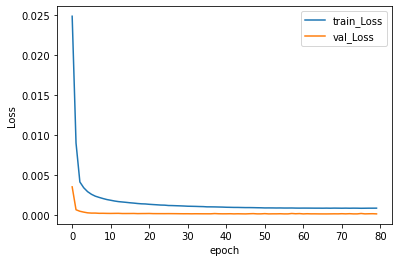

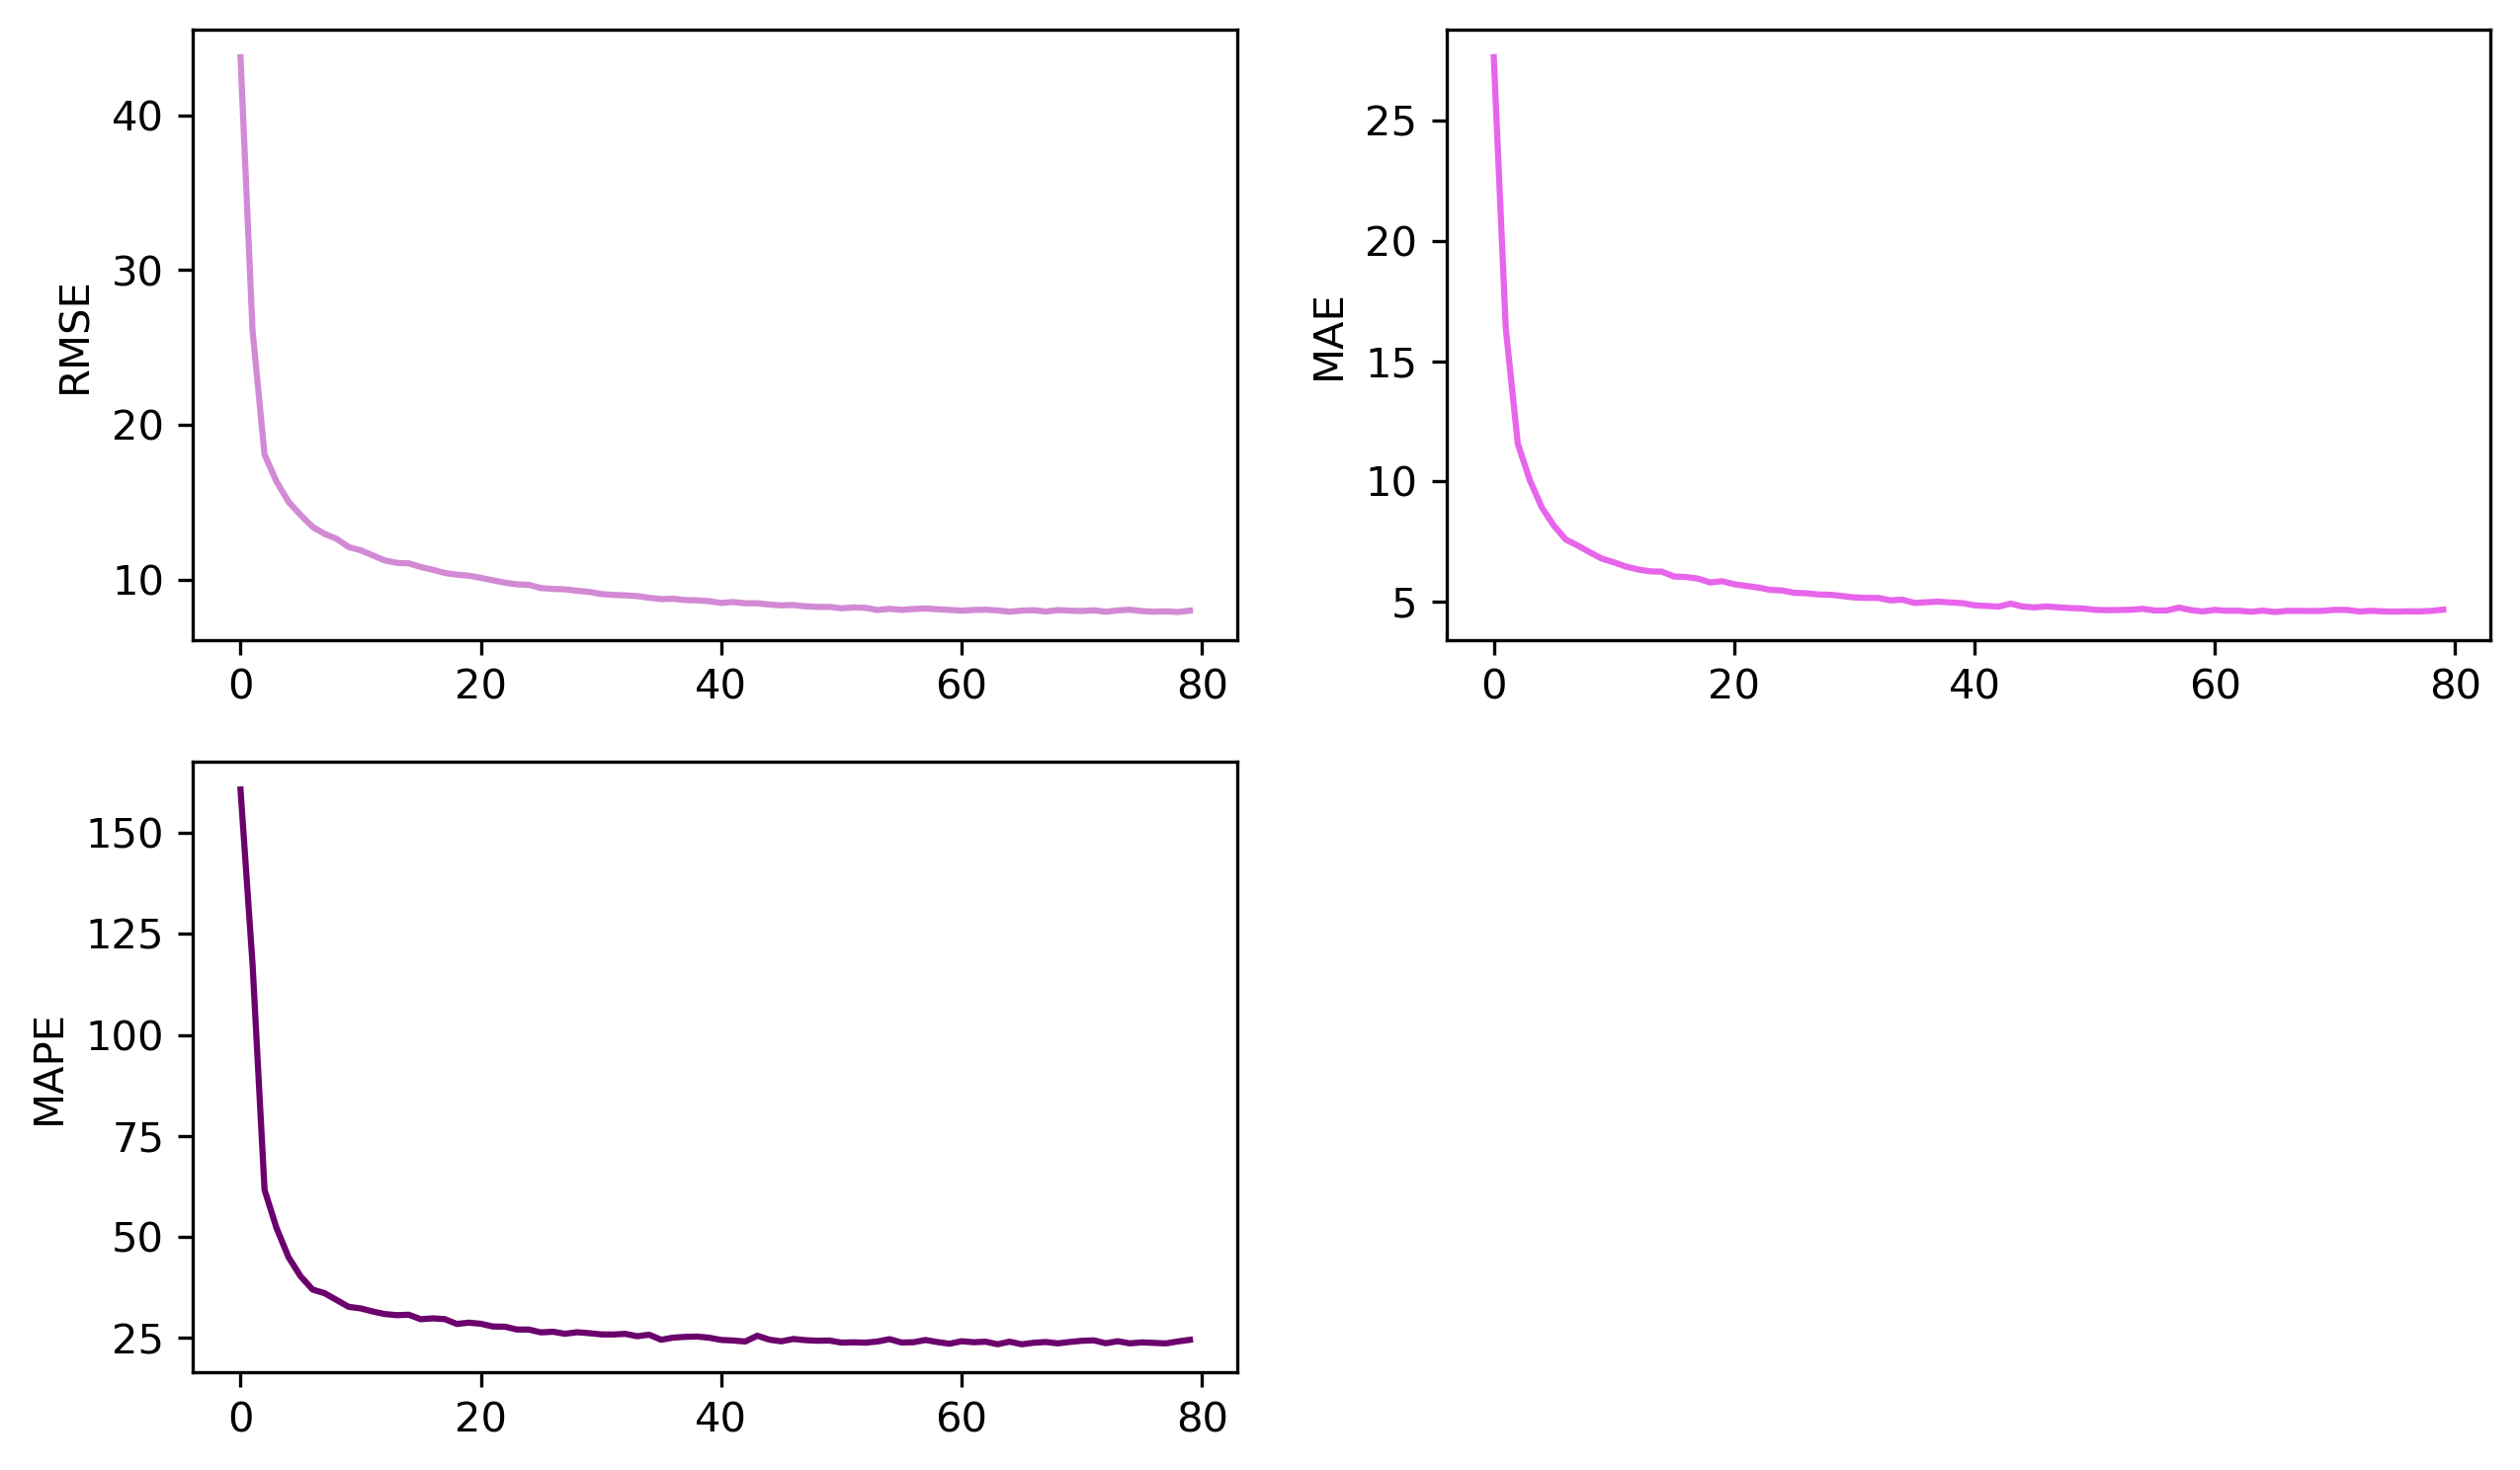

In [5]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## LSTM手动实现

In [ ]:
# 按照实验课要求，不使用Linear直接进行并行化计算, 而采用分开门合并又分开的方法

class My_legacyLSTM(nn.Module):
    def _init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_f = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_f = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.w_i = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_i = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.w_o = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_o = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.w_c = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_c = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
        #         合并参数
        f = torch.cat([self.w_f, self.u_f], dim=0)
        i = torch.cat([self.w_i, self.u_i], dim=0)
        o = torch.cat([self.w_o, self.u_o], dim=0)
        c = torch.cat([self.w_c, self.u_c], dim=0)

        self.b = torch.cat([self.b_f, self.b_i, self.b_o, self.b_c])
        self.gate = torch.cat([f, i, o, c], dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 需要初始化隐藏状态和细胞状态
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []

        for i in range(seq_len):
            input = torch.cat([x[:, i, :], h], dim=-1)
            # 参数拆分
            forget_gate, input_gate, output_gate, candidate_cell = (torch.matmul(input, self.gate) + self.b).chunk(4, -1)

            forget_gate, input_gate, output_gate = (self.sigmoid(g) for g in (forget_gate, input_gate, output_gate))

            # 三个门均通过hadamard积作用在每一个维度上。
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

In [ ]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        # todo need shift to cat with nn.parameters but not Linear
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

## GRU手动实现

In [ ]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h